# Notebook to QC Section 2.3 that examines extra terms in the $s^2$ equation. I expect these terms to close with a small residual similar to 'QC_diffusion'

In [2]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from xhistogram.xarray import histogram
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline
from datetime import datetime

# Open model output and check abbreviated term calculations are equal to their long form. For example, $\iint (2s^2-2s\overline{s})(E-P) \, dA$=$\iint (2s^{\prime}s)(E-P) \, dA$

In [9]:
#Open model output
path = glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds = xroms.open_mfnetcdf(path)
ds, grid = xroms.roms_dataset(ds)

#Indexing for nested grid
xislice = slice(271,404)
etaslice = slice(31,149)

In [21]:
dA = ds.dA.isel(eta_rho = etaslice, xi_rho = xislice)
eminusp_avg = (ds.evaporation-ds.rain)/1000

#S^prime^2 surface flux: (2*s^prime*s*(E-P))
dV = ds.dV.isel(eta_rho = etaslice, xi_rho = xislice)
V = dV.sum(dim = ['eta_rho', 's_rho', 'xi_rho'])
salt = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice)
sbar = (1/V)*(salt*dV).sum(dim = ['eta_rho', 'xi_rho','s_rho'])
sprime = ds.salt.isel(eta_rho = etaslice, xi_rho = xislice, s_rho = -1)-sbar
sprime2flux_avg = 2*(salt.isel(s_rho = -1))*sprime*eminusp_avg.isel(eta_rho = etaslice, xi_rho = xislice)
sprime2flux_int_avg = (sprime2flux_avg*dA).sum(['eta_rho', 'xi_rho'])

# #Alternative method: long version from Section 2.2. of manuscript
sprime2_long = (2*(salt.isel(s_rho = -1)**2)-2*salt.isel(s_rho = -1)*sbar)*eminusp_avg
sprime2_long_int_avg = (sprime2_long*dA).sum(['eta_rho', 'xi_rho'])

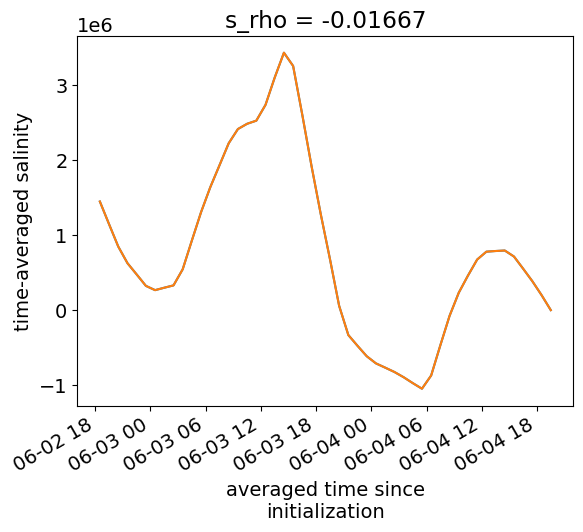

In [24]:
sprime2flux_int_avg[:50].plot()
sprime2_long_int_avg[:50].plot()

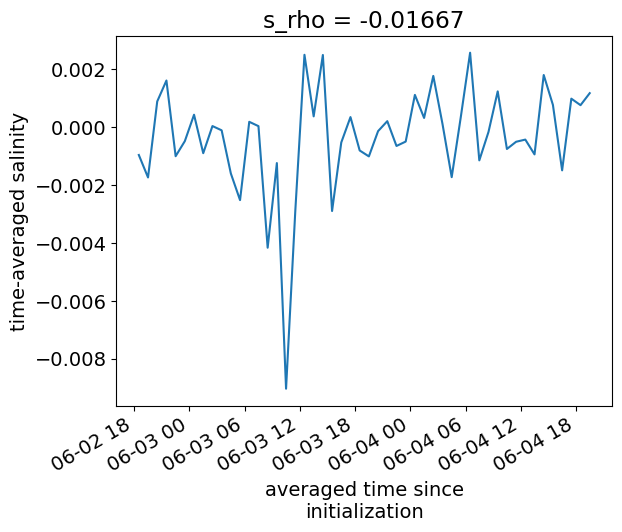

In [25]:
(sprime2flux_int_avg[:50]-sprime2_long_int_avg[:50]).plot()

# Great, the math was done correctly. 

# Open term calculation output 

In [3]:
#Tendency terms - all in .npy format
s2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/s2flux_ver1_2010_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/sprime2flux_ver1_2010_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
surface_extra = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/extra_ver1_2010_*.nc').surface_fluxes_extra.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Open another variable to extract time 
time = s2_surface.ocean_time.values

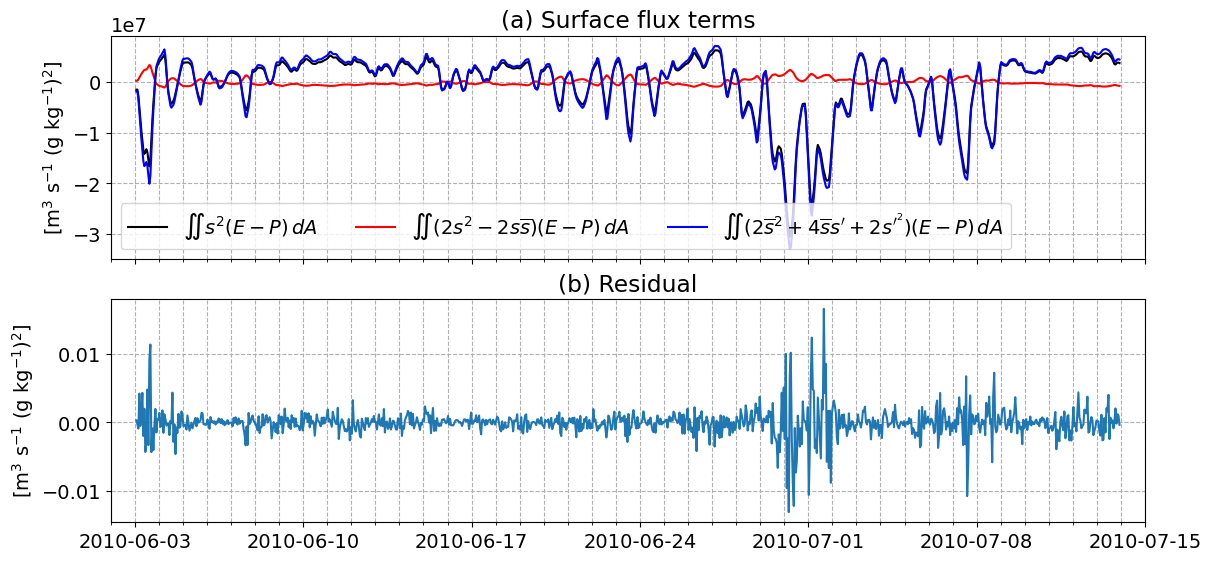

In [8]:
plt.rcParams.update({'font.size': 14})

myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

fig, ax = plt.subplots(2,1, figsize = (12,2.75*2), constrained_layout = True, sharey = False)

ax[0].plot(time, s2_surface, lw = 1.5, c = 'k', label = r'$\iint s^2(E-P) \, dA$')
ax[0].plot(time, sprime2_surface, lw = 1.5, c = 'r', label = r'$\iint (2s^2-2s\overline{s})(E-P) \, dA$')
ax[0].plot(time, surface_extra, lw = 1.5, c = 'b', label = r'$\iint (2\overline{s}^2+4\overline{s}s^\prime+2s^{\prime^2})(E-P) \, dA$')
ax[0].set_title('(a) Surface flux terms')
ax[0].legend(loc = 'lower left', ncol = 4)
ax[0].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[0].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[0].set_xticks(ticks = dates)
ax[0].grid(linestyle = '--')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])

ax[1].plot(time, s2_surface-(sprime2_surface+surface_extra), lw = 1.5)
ax[1].set_title('(b) Residual')
ax[1].grid(linestyle = '--')
ax[1].set_xlabel('Time [hrs]')
ax[1].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[1].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[1].set_xticks(ticks = dates)
ax[1].grid(linestyle = '--')
ax[1].set_xlabel('')
ax[1].set_xticklabels([])
ax[1].xaxis.set_major_formatter(myFmt)

for i in range(2):
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
    
# plt.savefig('QC_surface.jpg', dpi = 300, bbox_inches='tight')

# There is a small residual here, just as good as the diffusive flux term balance. All good here